## Imports

In [4]:
!pip install datasets

In [5]:
!pip install xgboost

In [6]:
!pip install imblearn

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

### Importing Dataset

In [8]:
dataset = load_dataset('weeebdev/diabetes')
print(dataset) 

DatasetDict({
    train: Dataset({
        features: ['Number of times pregnant', 'Plasma glucose concentration a 2 hours in an oral glucose tolerance test', 'Diastolic blood pressure (mm Hg)', 'Triceps skin fold thickness (mm)', '2-Hour serum insulin (mu U/ml)', 'Body mass index (weight in kg/(height in m)^2)', 'Diabetes pedigree function', 'Age (years)', 'Class variable'],
        num_rows: 768
    })
})


In [9]:
df = dataset["train"].to_pandas()
df.to_csv("diabetes.csv", index=False)

In [10]:
df

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [11]:
df.head()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Preprocessing

### Detecting missing values

In [12]:
df.isnull().sum()

Number of times pregnant                                                    0
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0
Diastolic blood pressure (mm Hg)                                            0
Triceps skin fold thickness (mm)                                            0
2-Hour serum insulin (mu U/ml)                                              0
Body mass index (weight in kg/(height in m)^2)                              0
Diabetes pedigree function                                                  0
Age (years)                                                                 0
Class variable                                                              0
dtype: int64

The dataset does not have any null values so no need for filling

In [13]:
df.duplicated().sum()

0

In [14]:
df.describe()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Number of times pregnant                                                  768 non-null    int64  
 1   Plasma glucose concentration a 2 hours in an oral glucose tolerance test  768 non-null    int64  
 2   Diastolic blood pressure (mm Hg)                                          768 non-null    int64  
 3   Triceps skin fold thickness (mm)                                          768 non-null    int64  
 4   2-Hour serum insulin (mu U/ml)                                            768 non-null    int64  
 5   Body mass index (weight in kg/(height in m)^2)                            768 non-null    float64
 6   Diabetes pedigree function                                         

All columns are numeric so no need for conversion

In [16]:
df['Class variable'].unique()

array([1, 0])

The target variable is only 0 or 1 which means it does not need encoding

In [17]:
df['Class variable'].value_counts()

Class variable
0    500
1    268
Name: count, dtype: int64

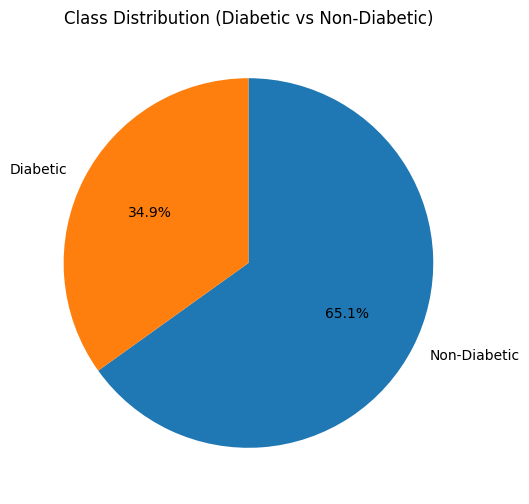

In [18]:
class_counts = df['Class variable'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    class_counts,
    labels=class_counts.index.map({0:"Non-Diabetic", 1:"Diabetic"}),
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title("Class Distribution (Diabetic vs Non-Diabetic)")
plt.show()

Data is unbalanced

May apply oversampling to the minority class

### Splitting Data

In [19]:
x = df.iloc[:,0:-1] # Features columns
y = df['Class variable'] # Target column

In [20]:
# 20%->test 8%->validation 72%->train
X_train,X_test,Y_train,Y_test = train_test_split(x, y, test_size=0.2, shuffle = True, random_state = 5)
X_train,X_val,Y_train,Y_val = train_test_split(X_train, Y_train, test_size=0.1, shuffle =True, random_state = 5) #0.1*0.8=8% val and 72% train

# print("X_train shape: {}".format(X_train.shape))
# print("X_test shape: {}".format(X_test.shape))
# print("X_val shape: {}".format(X_val.shape))
# print("y_train shape: {}".format(Y_train.shape))
# print("y_test shape: {}".format(Y_test.shape))
# print("y_val shape: {}".format(Y_val.shape))

### Visualizing Correlation Between features

In [21]:
# the relation between every varibale and the other
X_train.corr()

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years)
Number of times pregnant,1.000000,0.143977,0.163432,-0.070842,-0.069954,0.009104,-0.038742,0.546006
Plasma glucose concentration a 2 hours in an oral glucose tolerance test,0.143977,1.000000,0.158484,0.046377,0.309836,0.173828,0.117672,0.304307
Diastolic blood pressure (mm Hg),0.163432,0.158484,1.000000,0.216563,0.089655,0.305204,0.030735,0.246108
Triceps skin fold thickness (mm),-0.070842,0.046377,0.216563,1.000000,0.422953,0.432657,0.172626,-0.098203
2-Hour serum insulin (mu U/ml),-0.069954,0.309836,0.089655,0.422953,1.000000,0.211141,0.195158,-0.013983
Body mass index (weight in kg/(height in m)^2),0.009104,0.173828,0.305204,0.432657,0.211141,1.000000,0.118952,0.024848
Diabetes pedigree function,-0.038742,0.117672,0.030735,0.172626,0.195158,0.118952,1.000000,0.040371
Age (years),0.546006,0.304307,0.246108,-0.098203,-0.013983,0.024848,0.040371,1.000000


In [22]:
#the relation between every variable and the target variable
X_train.join(Y_train).corr()['Class variable']

Number of times pregnant                                                    0.226672
Plasma glucose concentration a 2 hours in an oral glucose tolerance test    0.452806
Diastolic blood pressure (mm Hg)                                            0.053601
Triceps skin fold thickness (mm)                                            0.059886
2-Hour serum insulin (mu U/ml)                                              0.145808
Body mass index (weight in kg/(height in m)^2)                              0.258445
Diabetes pedigree function                                                  0.178289
Age (years)                                                                 0.236888
Class variable                                                              1.000000
Name: Class variable, dtype: float64

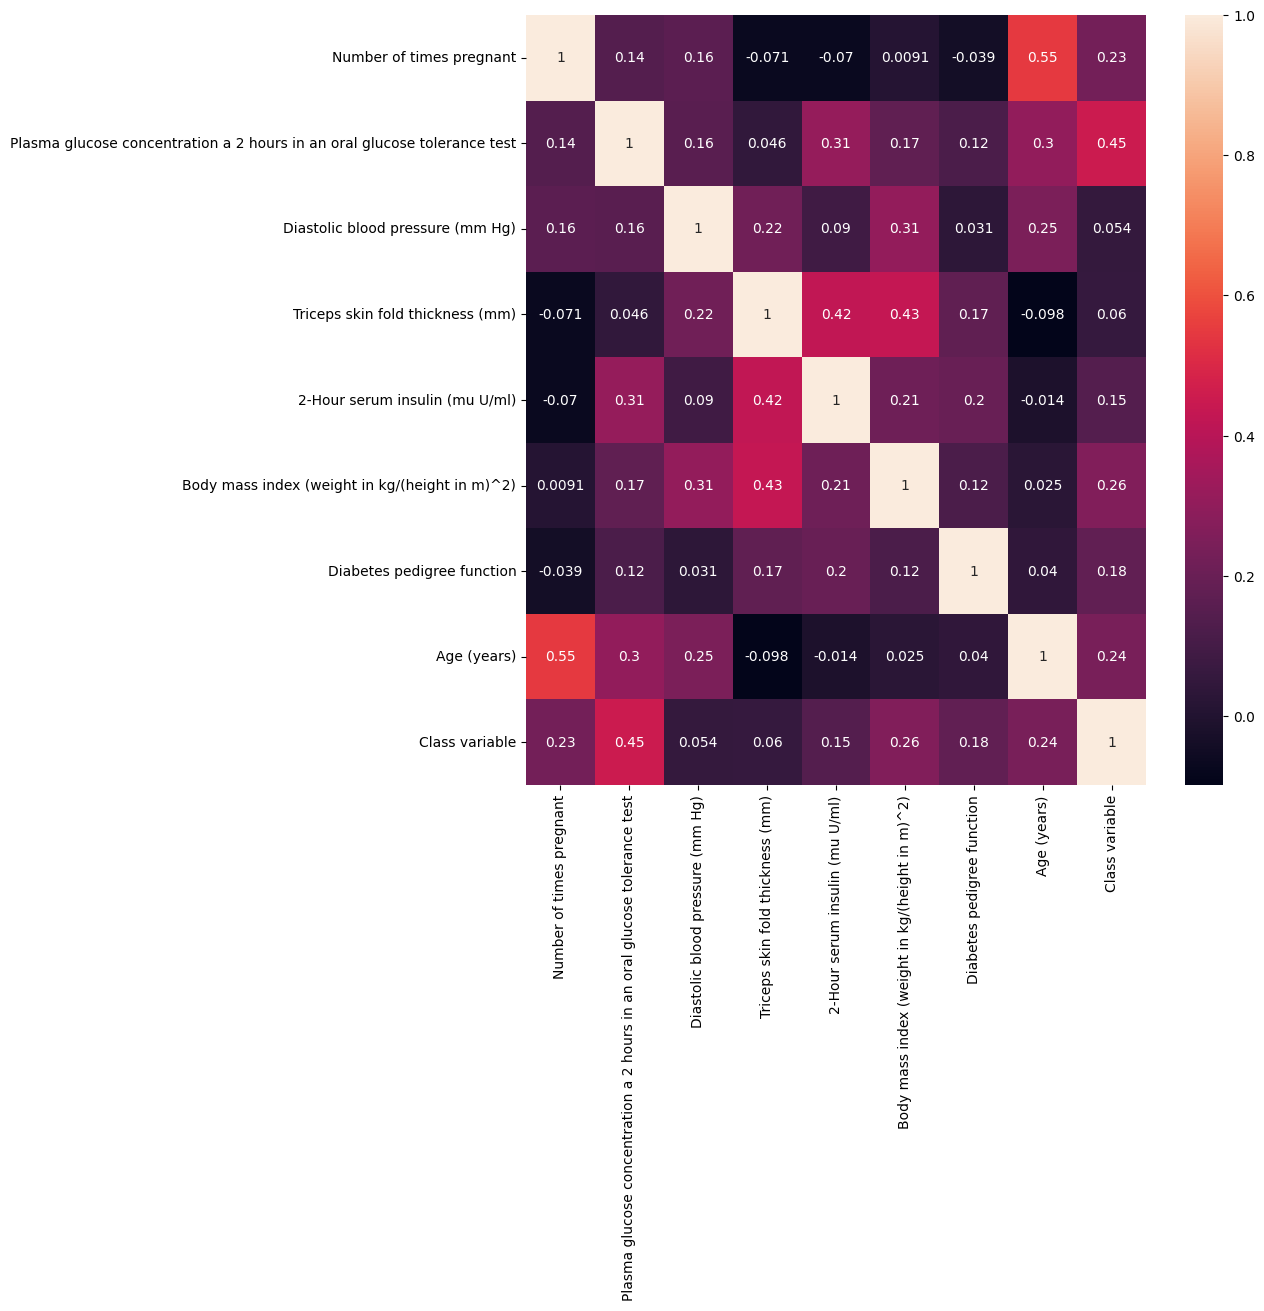

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = X_train.join(Y_train).corr()
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(corr, annot=True)
plt.show()

Plasma glucose has the greatest influence on diabetes classification. BMI, Age and pregnancies have a lower influence. Blood pressure and skin fold thickness are of very weak influence.

In [24]:
zero_counts = (df == 0).sum()
print(zero_counts)

Number of times pregnant                                                    111
Plasma glucose concentration a 2 hours in an oral glucose tolerance test      5
Diastolic blood pressure (mm Hg)                                             35
Triceps skin fold thickness (mm)                                            227
2-Hour serum insulin (mu U/ml)                                              374
Body mass index (weight in kg/(height in m)^2)                               11
Diabetes pedigree function                                                    0
Age (years)                                                                   0
Class variable                                                              500
dtype: int64


0 values here may be a place holder for missing values since some medical indicators can impossibaly be zero as BMI and Plasma glucose.

In [25]:
df= df[df['Plasma glucose concentration a 2 hours in an oral glucose tolerance test'] != 0]
print("New dataset size:", df.shape)

New dataset size: (763, 9)


Dropped the 5 rows where plasma glucose had a value of 0 because it is the most influential feature and 5 rows are not a lot with respect to the data sample size.

In [26]:
cols_with_missing = ["Diastolic blood pressure (mm Hg)", "Body mass index (weight in kg/(height in m)^2)"]

for col in cols_with_missing:
    median = df.loc[df[col] != 0, col].median()   # median of non-zero values
    df.loc[:,col] = df[col].replace(0, median)

In [27]:
df = df.drop(columns=["Triceps skin fold thickness (mm)", "2-Hour serum insulin (mu U/ml)"])
df

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0
4,0,137,40,43.1,2.288,33,1
...,...,...,...,...,...,...,...
763,10,101,76,32.9,0.171,63,0
764,2,122,70,36.8,0.340,27,0
765,5,121,72,26.2,0.245,30,0
766,1,126,60,30.1,0.349,47,1


In [28]:
zero_counts = (df == 0).sum()
print(zero_counts)

Number of times pregnant                                                    111
Plasma glucose concentration a 2 hours in an oral glucose tolerance test      0
Diastolic blood pressure (mm Hg)                                              0
Body mass index (weight in kg/(height in m)^2)                                0
Diabetes pedigree function                                                    0
Age (years)                                                                   0
Class variable                                                              497
dtype: int64


Dropped the features that had too many missing values and weak correlation with the target (like insulin and skin thickness), because imputing would add too much noise since the data will be synthetic. For features with only a few missing values (like BMI or blood pressure), I imputed using the median.

### Normalization

#### MaxMin Normalization

In [29]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler(feature_range=(0,1))
X_train = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scale.transform(X_test), columns=X_test.columns, index=X_test.index)
X_val = pd.DataFrame(scale.transform(X_val), columns=X_val.columns, index=X_val.index)

#### Z-score Standardization

In [30]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
X_train = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scale.transform(X_test), columns=X_test.columns, index=X_test.index)
X_val = pd.DataFrame(scale.transform(X_val), columns=X_val.columns, index=X_val.index)
    

In [31]:
results = []

def log_results(model_name, y_pred):
    report = classification_report(Y_test, y_pred, output_dict=True)
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(Y_test, y_pred),
        'Precision (Class 0)': report['0']['precision'],
        'Recall (Class 0)': report['0']['recall'],
        'F1 (Class 0)': report['0']['f1-score'],
        'Precision (Class 1)': report['1']['precision'],
        'Recall (Class 1)': report['1']['recall'],
        'F1 (Class 1)': report['1']['f1-score'],
         'Macro Precision': report['macro avg']['precision'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro F1': report['macro avg']['f1-score'],
    })

## KNN

### Hyperparameters Tuning

In [32]:
scores = []
for i in range(5,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    score = cross_val_score(knn, X_train, Y_train, cv=5)
    scores.append(np.mean(score))

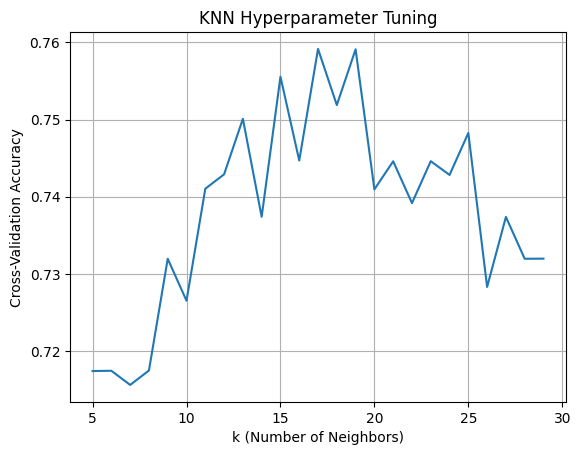

In [33]:
import matplotlib.pyplot as plt
k_values = [i for i in range (5,30)]
plt.plot(k_values, scores)
plt.xlabel("k (Number of Neighbors)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("KNN Hyperparameter Tuning")
plt.grid(True)
plt.show()

The optimum value is at k=19

### Knn Model

In [34]:
knn = KNeighborsClassifier(n_neighbors=19)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(Y_pred_knn,Y_test)
print("Accuracy:", accuracy_knn)

Accuracy: 0.7337662337662337


In [35]:
cm_knn = confusion_matrix(Y_test, Y_pred_knn)
print(cm_knn)
print(classification_report(Y_test, Y_pred_knn, target_names=['0','1']))

[[86 14]
 [27 27]]
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       100
           1       0.66      0.50      0.57        54

    accuracy                           0.73       154
   macro avg       0.71      0.68      0.69       154
weighted avg       0.73      0.73      0.72       154



In [36]:
log_results('KNN', Y_pred_knn)

In [37]:
results

[{'Model': 'KNN',
  'Accuracy': 0.7337662337662337,
  'Precision (Class 0)': 0.7610619469026548,
  'Recall (Class 0)': 0.86,
  'F1 (Class 0)': 0.8075117370892019,
  'Precision (Class 1)': 0.6585365853658537,
  'Recall (Class 1)': 0.5,
  'F1 (Class 1)': 0.5684210526315789,
  'Macro Precision': 0.7097992661342543,
  'Macro Recall': 0.6799999999999999,
  'Macro F1': 0.6879663948603905}]

## SVM

### Linear kernal

#### Hyperparameter tuning

In [38]:
#finding the optimum c value
#used gridsearch with a defined paramater dictionary to trya ll possible combinations
svm_linear = svm.SVC(kernel='linear')
param_grid = {
    'C': np.logspace(-4, 4, 20)  
}
grid_search = GridSearchCV(
    estimator=svm_linear,
    param_grid=param_grid,
    cv=5,             
    scoring='accuracy', 
    verbose=True,
    n_jobs=1           
)
grid_search

,estimator,SVC(kernel='linear')
,param_grid,{'C': array([1.0000...00000000e+04])}
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1.0


In [39]:
best_lin = grid_search.fit(x,y)
best_lin.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,C,4.281332398719396
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Parameters from tuning

In [40]:
svm_lin_tune = svm.SVC(kernel = 'linear', **grid_search.best_params_)
svm_lin_tune.fit(X_train, Y_train)
Y_pred_lin_tune = svm_lin_tune.predict(X_test)
accuracy_lin_tune = accuracy_score(Y_test, Y_pred_lin_tune)
print("Accuracy:",accuracy_lin_tune)

Accuracy: 0.8051948051948052


In [41]:
cm_lin_tune = confusion_matrix(Y_test, Y_pred_lin_tune)
print(cm_lin_tune)
print(classification_report(Y_test, Y_pred_lin_tune, target_names=['0','1']))

[[89 11]
 [19 35]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.86       100
           1       0.76      0.65      0.70        54

    accuracy                           0.81       154
   macro avg       0.79      0.77      0.78       154
weighted avg       0.80      0.81      0.80       154



In [42]:
log_results('SVM_lin', Y_pred_lin_tune)

### RBF Kernel

#### Hyperparameter tuning

In [43]:
#finding the optimum c value
svm_rbf = svm.SVC(kernel='rbf')
param_grid_rbf = {
    'C': np.logspace(-4, 4, 20),
    'gamma': [0.01, 0.1, 1, 10]
}
grid_search_rbf = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid_rbf,
    cv=5,             
    scoring='accuracy', 
    verbose=True,
    n_jobs=1           
)
grid_search_rbf


,estimator,SVC()
,param_grid,"{'C': array([1.0000...00000000e+04]), 'gamma': [0.01, 0.1, ...]}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1.0


In [44]:
best_rbf = grid_search_rbf.fit(x,y)
best_rbf.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


,C,0.615848211066026
,kernel,'rbf'
,degree,3
,gamma,0.01
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Defualt Parameters

In [45]:
svm_rbf = svm.SVC(kernel = 'rbf')
svm_rbf.fit(X_train, Y_train)
Y_pred_rbf = svm_rbf.predict(X_test)
accuracy_rbf = accuracy_score(Y_test, Y_pred_rbf)
print("Accuracy:",accuracy_rbf)

Accuracy: 0.7987012987012987


In [46]:
cm_rbf = confusion_matrix(Y_test, Y_pred_rbf)
print(cm_rbf)
print(classification_report(Y_test, Y_pred_rbf, target_names=['0','1']))

[[87 13]
 [18 36]]
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       100
           1       0.73      0.67      0.70        54

    accuracy                           0.80       154
   macro avg       0.78      0.77      0.77       154
weighted avg       0.80      0.80      0.80       154



##### Parameters from tuning

In [47]:
svm_rbf_tune = svm.SVC(kernel = 'rbf',**grid_search_rbf.best_params_ )
svm_rbf_tune.fit(X_train, Y_train)
Y_pred_rbf_tune = svm_rbf_tune.predict(X_test)
accuracy_rbf_tune = accuracy_score(Y_test, Y_pred_rbf_tune)
print("Accuracy:",accuracy_rbf_tune)

Accuracy: 0.7987012987012987


In [48]:
cm_rbf_tune = confusion_matrix(Y_test, Y_pred_rbf_tune)
print(cm_rbf_tune)
print(classification_report(Y_test, Y_pred_rbf_tune, target_names=['0','1']))

[[91  9]
 [22 32]]
              precision    recall  f1-score   support

           0       0.81      0.91      0.85       100
           1       0.78      0.59      0.67        54

    accuracy                           0.80       154
   macro avg       0.79      0.75      0.76       154
weighted avg       0.80      0.80      0.79       154



In [49]:
log_results('SVM_RBF_default' , Y_pred_rbf)

### Sigmoid Kernel

#### Hyperparameters tuning

In [50]:
#finding the optimum c value
svm_sig = svm.SVC(kernel='sigmoid')
param_grid_sig = {
    'C': np.logspace(-4, 4, 20),
    'gamma': [0.01, 0.1, 1, 10]
}
grid_search_sig = GridSearchCV(
    estimator=svm_sig,
    param_grid=param_grid_sig,
    cv=5,             
    scoring='accuracy', 
    verbose=True,
    n_jobs=1           
)
grid_search_sig


,estimator,SVC(kernel='sigmoid')
,param_grid,"{'C': array([1.0000...00000000e+04]), 'gamma': [0.01, 0.1, ...]}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,C,1.0


In [51]:
best_sig = grid_search_sig.fit(x,y)
best_sig.best_estimator_

Fitting 5 folds for each of 80 candidates, totalling 400 fits


,C,0.0001
,kernel,'sigmoid'
,degree,3
,gamma,0.01
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### Default parameters

In [52]:
svm_sig = svm.SVC(kernel = 'sigmoid')
svm_sig.fit(X_train, Y_train)
Y_pred_sig = svm_sig.predict(X_test)
accuracy_sig = accuracy_score(Y_test, Y_pred_sig)
print("Accuracy:",accuracy_sig)

Accuracy: 0.7402597402597403


In [53]:
cm_sig = confusion_matrix(Y_test, Y_pred_sig)
print(cm_sig)
print(classification_report(Y_test, Y_pred_sig, target_names=['0','1']))

[[83 17]
 [23 31]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.65      0.57      0.61        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.73      0.74      0.74       154



##### Parameters from tuning

In [54]:
svm_sig_tune = svm.SVC(kernel = 'sigmoid', **grid_search_sig.best_params_)
svm_sig_tune.fit(X_train, Y_train)
Y_pred_sig_tune = svm_sig_tune.predict(X_test)
accuracy_sig_tune = accuracy_score(Y_test, Y_pred_sig_tune)
print("Accuracy:",accuracy_sig_tune)

Accuracy: 0.6493506493506493


In [55]:
cm_sig_tune = confusion_matrix(Y_test, Y_pred_sig_tune)
print(cm_sig_tune)
print(classification_report(Y_test, Y_pred_sig_tune, target_names=['0','1']))

[[100   0]
 [ 54   0]]
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       100
           1       0.00      0.00      0.00        54

    accuracy                           0.65       154
   macro avg       0.32      0.50      0.39       154
weighted avg       0.42      0.65      0.51       154



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [56]:
log_results('SVM_sig_tuned', Y_pred_sig_tune)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


The default sigmoid kernel has extermely low accuracy. It is the least accuracy of all models.

The hyperprameters used enhanced the accuracy by about 50%.

Both models have extremely low recall and precision and F1 values for class 1 specifically.

In [57]:
results

[{'Model': 'KNN',
  'Accuracy': 0.7337662337662337,
  'Precision (Class 0)': 0.7610619469026548,
  'Recall (Class 0)': 0.86,
  'F1 (Class 0)': 0.8075117370892019,
  'Precision (Class 1)': 0.6585365853658537,
  'Recall (Class 1)': 0.5,
  'F1 (Class 1)': 0.5684210526315789,
  'Macro Precision': 0.7097992661342543,
  'Macro Recall': 0.6799999999999999,
  'Macro F1': 0.6879663948603905},
 {'Model': 'SVM_lin',
  'Accuracy': 0.8051948051948052,
  'Precision (Class 0)': 0.8240740740740741,
  'Recall (Class 0)': 0.89,
  'F1 (Class 0)': 0.8557692307692307,
  'Precision (Class 1)': 0.7608695652173914,
  'Recall (Class 1)': 0.6481481481481481,
  'F1 (Class 1)': 0.7,
  'Macro Precision': 0.7924718196457328,
  'Macro Recall': 0.769074074074074,
  'Macro F1': 0.7778846153846153},
 {'Model': 'SVM_RBF_default',
  'Accuracy': 0.7987012987012987,
  'Precision (Class 0)': 0.8285714285714286,
  'Recall (Class 0)': 0.87,
  'F1 (Class 0)': 0.848780487804878,
  'Precision (Class 1)': 0.7346938775510204,
  'R

### Polynomial Kernel

#### Hyperparamter tuning

In [58]:
d_values = [i for i in range (1,10)]
scores = []

for d in d_values:
    poly = svm.SVC(kernel = 'poly' , degree = d )
    score = cross_val_score(poly, X_train, Y_train, cv=5)
    scores.append(np.mean(score))

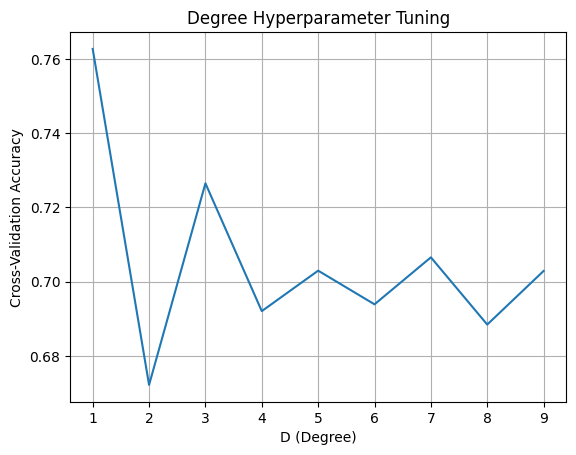

In [59]:
plt.plot(d_values, scores)
plt.xlabel("D (Degree)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("Degree Hyperparameter Tuning")
plt.grid(True)
plt.show()

##### Defualt parameters

In [60]:
svm_pol = svm.SVC(kernel = 'poly', degree=1, random_state=42)
svm_pol.fit(X_train, Y_train)
Y_pred_pol = svm_pol.predict(X_test)
accuracy_pol = accuracy_score(Y_test, Y_pred_pol)
print("Accuracy:",accuracy_pol)

Accuracy: 0.8116883116883117


In [61]:
cm_pol = confusion_matrix(Y_test, Y_pred_pol)
print(cm_pol)
print(classification_report(Y_test, Y_pred_pol, target_names=['0','1']))

[[90 10]
 [19 35]]
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       100
           1       0.78      0.65      0.71        54

    accuracy                           0.81       154
   macro avg       0.80      0.77      0.78       154
weighted avg       0.81      0.81      0.81       154



In [62]:
log_results('SVM_poly' , Y_pred_pol)

## Logistic Regression

### Hyperparameters Tuning

In [63]:
param_grid = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga']
}
]

log_reg = LogisticRegression()

In [64]:
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(log_reg ,param_grid = param_grid, cv = 5, verbose=True,n_jobs=1)
clf

,estimator,LogisticRegression()
,param_grid,"[{'C': array([1.0000...00000000e+04]), 'penalty': ['l1', 'l2', ...], 'solver': ['lbfgs', 'newton-cg', ...]}]"
,scoring,None
,n_jobs,1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [65]:
best_clf = clf.fit(x,y)
best_clf.best_estimator_

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.08858667904100823
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### Logistic regression model

#### Defualt parameters

In [66]:
log_reg = LogisticRegression()
log_reg = log_reg.fit(X_train, Y_train)
Y_pred_log = log_reg.predict(X_test)
accuracy_log = accuracy_score(Y_pred_log,Y_test)
print("Accuracy:", accuracy_log)

Accuracy: 0.7987012987012987


In [67]:
cm_log = confusion_matrix(Y_test, Y_pred_log)
print(cm_log)
print(classification_report(Y_test, Y_pred_log, target_names=['0','1']))

[[88 12]
 [19 35]]
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       100
           1       0.74      0.65      0.69        54

    accuracy                           0.80       154
   macro avg       0.78      0.76      0.77       154
weighted avg       0.80      0.80      0.80       154



### Parameters from tuning

In [68]:
log_reg_tuned = LogisticRegression(**clf.best_params_)
log_reg_tuned.fit(X_train, Y_train)
Y_pred_log_tuned = log_reg_tuned.predict(X_test)
accuracy_log_tuned = accuracy_score(Y_pred_log_tuned,Y_test)
print("Accuracy:", accuracy_log_tuned)

Accuracy: 0.7987012987012987


In [69]:
cm_log_tuned = confusion_matrix(Y_test, Y_pred_log_tuned)
print(cm_log_tuned)
print(classification_report(Y_test, Y_pred_log_tuned, target_names=['0','1']))

[[89 11]
 [20 34]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       100
           1       0.76      0.63      0.69        54

    accuracy                           0.80       154
   macro avg       0.79      0.76      0.77       154
weighted avg       0.80      0.80      0.79       154



In [70]:
log_results('Logistic_reg', Y_pred_log_tuned)

## Decsion Trees

In [71]:
df

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,33.6,0.627,50,1
1,1,85,66,26.6,0.351,31,0
2,8,183,64,23.3,0.672,32,1
3,1,89,66,28.1,0.167,21,0
4,0,137,40,43.1,2.288,33,1
...,...,...,...,...,...,...,...
763,10,101,76,32.9,0.171,63,0
764,2,122,70,36.8,0.340,27,0
765,5,121,72,26.2,0.245,30,0
766,1,126,60,30.1,0.349,47,1


In [72]:
print(df['Number of times pregnant'].unique())
print(df['Number of times pregnant'].min())
print(df['Number of times pregnant'].max())

[ 6  1  8  0  5  3 10  2  4  7  9 11 13 15 17 12 14]
0
17


In [73]:
print(df['Plasma glucose concentration a 2 hours in an oral glucose tolerance test'].unique())
print(df['Plasma glucose concentration a 2 hours in an oral glucose tolerance test'].min())
print(df['Plasma glucose concentration a 2 hours in an oral glucose tolerance test'].max())

[148  85 183  89 137 116  78 115 197 125 110 168 139 189 166 100 118 107
 103 126  99 196 119 143 147  97 145 117 109 158  88  92 122 138 102  90
 111 180 133 106 171 159 146  71 105 101 176 150  73 187  84  44 141 114
  95 129  79  62 131 112 113  74  83 136  80 123  81 134 142 144  93 163
 151  96 155  76 160 124 162 132 120 173 170 128 108 154  57 156 153 188
 152 104  87  75 179 130 194 181 135 184 140 177 164  91 165  86 193 191
 161 167  77 182 157 178  61  98 127  82  72 172  94 175 195  68 186 198
 121  67 174 199  56 169 149  65 190]
44
199


In [74]:
print(df['Diastolic blood pressure (mm Hg)'].unique())
print(df['Diastolic blood pressure (mm Hg)'].min())
print(df['Diastolic blood pressure (mm Hg)'].max())

[ 72  66  64  40  74  50  70  96  92  80  60  84  30  88  90  94  76  82
  75  58  78  68 110  56  62  85  86  44  65 108  55  48 122  54  52  98
 104  95  46 102 100  61  24  38 106 114]
24
122


In [75]:
print(df['Body mass index (weight in kg/(height in m)^2)'].unique())
print(df['Body mass index (weight in kg/(height in m)^2)'].min())
print(df['Body mass index (weight in kg/(height in m)^2)'].max())

[33.6 26.6 23.3 28.1 43.1 25.6 31.  35.3 30.5 32.3 37.6 38.  27.1 30.1
 25.8 30.  45.8 29.6 43.3 34.6 39.3 35.4 39.8 29.  36.6 31.1 39.4 23.2
 22.2 34.1 36.  31.6 24.8 19.9 27.6 24.  33.2 32.9 38.2 37.1 34.  40.2
 22.7 45.4 27.4 42.  29.7 28.  39.1 19.4 24.2 24.4 33.7 34.7 23.  37.7
 46.8 40.5 41.5 25.  25.4 32.8 32.5 42.7 19.6 28.9 28.6 43.4 35.1 32.
 32.6 43.2 22.4 29.3 24.6 48.8 32.4 38.5 26.5 19.1 46.7 23.8 24.7 33.9
 20.4 28.7 49.7 39.  26.1 22.5 39.6 29.5 34.3 37.4 33.3 31.2 28.2 53.2
 34.2 26.8 55.  42.9 34.5 27.9 38.3 21.1 33.8 30.8 36.9 39.5 27.3 21.9
 40.6 47.9 50.  25.2 40.9 37.2 44.2 29.9 31.9 28.4 43.5 32.7 67.1 45.
 34.9 35.9 22.6 33.1 30.4 52.3 24.3 22.9 34.8 30.9 40.1 23.9 37.5 35.5
 27.7 42.8 42.6 41.8 35.8 37.8 28.8 23.6 35.7 36.7 45.2 44.  46.2 35.
 43.6 44.1 18.4 29.2 25.9 32.1 36.3 40.  25.1 27.5 45.6 27.8 24.9 25.3
 37.9 27.  26.  38.7 20.8 36.1 30.7 52.9 21.  39.7 25.5 26.2 19.3 38.1
 23.5 45.5 23.1 39.9 36.8 21.8 42.2 34.4 27.2 36.5 29.8 39.2 38.4 36.2
 48.3 20.

In [76]:
print(df['Diabetes pedigree function'].unique())
print(df['Diabetes pedigree function'].min())
print(df['Diabetes pedigree function'].max())

[0.627 0.351 0.672 0.167 2.288 0.201 0.248 0.134 0.158 0.232 0.191 0.537
 1.441 0.398 0.587 0.484 0.551 0.254 0.183 0.529 0.704 0.388 0.451 0.263
 0.205 0.257 0.487 0.245 0.337 0.546 0.851 0.267 0.188 0.512 0.966 0.42
 0.665 0.503 1.39  0.271 0.696 0.235 0.721 0.294 1.893 0.564 0.586 0.344
 0.305 0.491 0.526 0.342 0.467 0.718 0.962 1.781 0.173 0.304 0.27  0.699
 0.258 0.203 0.855 0.845 0.334 0.189 0.867 0.411 0.583 0.231 0.396 0.391
 0.37  0.307 0.14  0.102 0.767 0.237 0.227 0.698 0.178 0.324 0.153 0.165
 0.443 0.261 0.277 0.761 0.255 0.13  0.323 0.356 0.325 1.222 0.179 0.262
 0.283 0.93  0.801 0.207 0.287 0.336 0.247 0.199 0.543 0.192 0.588 0.539
 0.22  0.654 0.223 0.759 0.26  0.404 0.186 0.278 0.496 0.452 0.403 0.741
 0.361 1.114 0.457 0.647 0.088 0.597 0.532 0.703 0.159 0.268 0.286 0.318
 0.272 0.572 0.096 1.4   0.218 0.085 0.399 0.432 1.189 0.687 0.137 0.637
 0.833 0.229 0.817 0.204 0.368 0.743 0.722 0.256 0.709 0.471 0.495 0.18
 0.542 0.773 0.678 0.719 0.382 0.319 0.19  0.956 0.08

In [77]:
print(df['Age (years)'].unique())
print(df['Age (years)'].min())
print(df['Age (years)'].max())

[50 31 32 21 33 30 26 29 53 54 34 57 59 51 27 41 43 22 38 60 28 45 35 46
 56 37 48 40 25 24 58 42 44 39 36 23 61 69 62 55 65 47 52 66 49 63 67 72
 81 64 70 68]
21
81


### Hyperparameter tuning

In [78]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

for depth in range(1, 30):
    dt = DecisionTreeClassifier(max_depth=depth, random_state=8)
    dt.fit(X_train, Y_train)
    Y_val_pred = dt.predict(X_val)
    acc = accuracy_score(Y_val, Y_val_pred)
    print(f"Depth={depth} -> Validation Accuracy: {acc:.4f}")

Depth=1 -> Validation Accuracy: 0.7258
Depth=2 -> Validation Accuracy: 0.7258
Depth=3 -> Validation Accuracy: 0.7097
Depth=4 -> Validation Accuracy: 0.7581
Depth=5 -> Validation Accuracy: 0.7258
Depth=6 -> Validation Accuracy: 0.6935
Depth=7 -> Validation Accuracy: 0.7419
Depth=8 -> Validation Accuracy: 0.7258
Depth=9 -> Validation Accuracy: 0.7742
Depth=10 -> Validation Accuracy: 0.7258
Depth=11 -> Validation Accuracy: 0.7097
Depth=12 -> Validation Accuracy: 0.7258
Depth=13 -> Validation Accuracy: 0.6935
Depth=14 -> Validation Accuracy: 0.7581
Depth=15 -> Validation Accuracy: 0.7581
Depth=16 -> Validation Accuracy: 0.7581
Depth=17 -> Validation Accuracy: 0.7581
Depth=18 -> Validation Accuracy: 0.7581
Depth=19 -> Validation Accuracy: 0.7581
Depth=20 -> Validation Accuracy: 0.7581
Depth=21 -> Validation Accuracy: 0.7581
Depth=22 -> Validation Accuracy: 0.7581
Depth=23 -> Validation Accuracy: 0.7581
Depth=24 -> Validation Accuracy: 0.7581
Depth=25 -> Validation Accuracy: 0.7581
Depth=26 

#### Defualt parameters with no discretization

In [79]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=8)
dt.fit(X_train, Y_train)
Y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(Y_pred_dt, Y_test)
print("Accuracy:", accuracy_dt)

Accuracy: 0.6948051948051948


In [80]:
cm_dt = confusion_matrix(Y_test, Y_pred_dt)
print(cm_dt)
print(classification_report(Y_test, Y_pred_dt, target_names=['0','1']))

[[80 20]
 [27 27]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       100
           1       0.57      0.50      0.53        54

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.69      0.69      0.69       154



#### Parameters from tuning

In [81]:
dt_tune = DecisionTreeClassifier(max_depth = 2, random_state=8)
dt_tune.fit(X_train, Y_train)
Y_pred_dt_tune = dt_tune.predict(X_test)
accuracy_dt_tune = accuracy_score(Y_pred_dt_tune, Y_test)
print("Accuracy:", accuracy_dt_tune)

Accuracy: 0.7597402597402597


In [82]:
cm_dt_tune = confusion_matrix(Y_test, Y_pred_dt)
print(cm_dt_tune)
print(classification_report(Y_test, Y_pred_dt_tune, target_names=['0','1']))

[[80 20]
 [27 27]]
              precision    recall  f1-score   support

           0       0.75      0.94      0.84       100
           1       0.79      0.43      0.55        54

    accuracy                           0.76       154
   macro avg       0.77      0.68      0.69       154
weighted avg       0.77      0.76      0.74       154



In [83]:
log_results('Decision_Trees_tuned', Y_pred_dt_tune)

## Random forests

### Hyperparameter tuning

In [84]:
param_dist_rf = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf_tune = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf_tune, 
                                 param_distributions = param_dist_rf, 
                                 n_iter=50, 
                                 cv=5)
rand_search.fit(X_train, Y_train)

,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': <scipy.stats....x7fec15b14280>, 'n_estimators': <scipy.stats....x7fec15ebb910>}"
,n_iter,50
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [85]:
best_rf = rand_search.best_estimator_
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 5, 'n_estimators': 216}


#### Parameters from tuning

In [86]:
rf_tune = RandomForestClassifier(max_depth = 5, n_estimators = 492)
rf_tune.fit(X_train, Y_train)
Y_pred_rf_tune = rf_tune.predict(X_test)
accuracy_rf_tune = accuracy_score(Y_pred_rf_tune, Y_test)
print("Accuracy:", accuracy_rf_tune)

Accuracy: 0.7987012987012987


In [87]:
cm_rf_tune = confusion_matrix(Y_test, Y_pred_rf_tune)
print(cm_rf_tune)
print(classification_report(Y_test, Y_pred_rf_tune, target_names=['0','1']))

[[89 11]
 [20 34]]
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       100
           1       0.76      0.63      0.69        54

    accuracy                           0.80       154
   macro avg       0.79      0.76      0.77       154
weighted avg       0.80      0.80      0.79       154



In [88]:
log_results('Random_forests_tune', Y_pred_rf_tune)

## XGBOOST

### Hyperparameter tuning

In [89]:
import xgboost as xgb

param_dist_x = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
x_tune = xgb.XGBClassifier(objective='binary:logistic')
rand_search_x = RandomizedSearchCV(x_tune, 
                                 param_distributions = param_dist_x, 
                                 n_iter=50, 
                                 cv=5)
rand_search_x.fit(X_train, Y_train)

,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'max_depth': <scipy.stats....x7fec15ac78e0>, 'n_estimators': <scipy.stats....x7fec15fefcd0>}"
,n_iter,50
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [90]:
best_x = rand_search_x.best_estimator_
print('Best hyperparameters:',  rand_search_x.best_params_)

Best hyperparameters: {'max_depth': 1, 'n_estimators': 265}


#### Default parameters

In [91]:
import xgboost as xgb

xgb = xgb.XGBClassifier(objective='binary:logistic')
xgb.fit(X_train, Y_train)
Y_pred_xgb = xgb.predict(X_test)
accuracy_xgb = accuracy_score(Y_pred_xgb, Y_test)
print("Accuracy", accuracy_xgb)

Accuracy 0.7922077922077922


In [92]:
cm_xgb = confusion_matrix(Y_test, Y_pred_xgb)
print(cm_xgb)
print(classification_report(Y_test, Y_pred_xgb, target_names=['0','1']))

[[83 17]
 [15 39]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       100
           1       0.70      0.72      0.71        54

    accuracy                           0.79       154
   macro avg       0.77      0.78      0.77       154
weighted avg       0.79      0.79      0.79       154



#### Parameters from tuning

In [93]:
import xgboost as xgb

xgb_tune = xgb.XGBClassifier(objective='binary:logistic', max_depth =1, n_estimators = 260)
xgb_tune.fit(X_train, Y_train)
Y_pred_xgb_tune = xgb_tune.predict(X_test)
accuracy_xgb_tune = accuracy_score(Y_pred_xgb_tune, Y_test)
print("Accuracy", accuracy_xgb_tune)

Accuracy 0.7792207792207793


In [94]:
cm_xgb_tune = confusion_matrix(Y_test, Y_pred_xgb_tune)
print(cm_xgb_tune)
print(classification_report(Y_test, Y_pred_xgb_tune, target_names=['0','1']))

[[88 12]
 [22 32]]
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       100
           1       0.73      0.59      0.65        54

    accuracy                           0.78       154
   macro avg       0.76      0.74      0.75       154
weighted avg       0.77      0.78      0.77       154



In [95]:
log_results('XGBOOST_tune', Y_pred_xgb)

## Summary of results table

In [96]:
results

[{'Model': 'KNN',
  'Accuracy': 0.7337662337662337,
  'Precision (Class 0)': 0.7610619469026548,
  'Recall (Class 0)': 0.86,
  'F1 (Class 0)': 0.8075117370892019,
  'Precision (Class 1)': 0.6585365853658537,
  'Recall (Class 1)': 0.5,
  'F1 (Class 1)': 0.5684210526315789,
  'Macro Precision': 0.7097992661342543,
  'Macro Recall': 0.6799999999999999,
  'Macro F1': 0.6879663948603905},
 {'Model': 'SVM_lin',
  'Accuracy': 0.8051948051948052,
  'Precision (Class 0)': 0.8240740740740741,
  'Recall (Class 0)': 0.89,
  'F1 (Class 0)': 0.8557692307692307,
  'Precision (Class 1)': 0.7608695652173914,
  'Recall (Class 1)': 0.6481481481481481,
  'F1 (Class 1)': 0.7,
  'Macro Precision': 0.7924718196457328,
  'Macro Recall': 0.769074074074074,
  'Macro F1': 0.7778846153846153},
 {'Model': 'SVM_RBF_default',
  'Accuracy': 0.7987012987012987,
  'Precision (Class 0)': 0.8285714285714286,
  'Recall (Class 0)': 0.87,
  'F1 (Class 0)': 0.848780487804878,
  'Precision (Class 1)': 0.7346938775510204,
  'R

In [98]:
table = pd.DataFrame(results)

# Round for nicer display
table = table.round(3)

# Display table
print(table.to_string(index=False))

               Model  Accuracy  Precision (Class 0)  Recall (Class 0)  F1 (Class 0)  Precision (Class 1)  Recall (Class 1)  F1 (Class 1)  Macro Precision  Macro Recall  Macro F1
                 KNN     0.734                0.761              0.86         0.808                0.659             0.500         0.568            0.710         0.680     0.688
             SVM_lin     0.805                0.824              0.89         0.856                0.761             0.648         0.700            0.792         0.769     0.778
     SVM_RBF_default     0.799                0.829              0.87         0.849                0.735             0.667         0.699            0.782         0.768     0.774
       SVM_sig_tuned     0.649                0.649              1.00         0.787                0.000             0.000         0.000            0.325         0.500     0.394
            SVM_poly     0.812                0.826              0.90         0.861                0.778      

### Conclusions


SVM model using the sigmoid kernel had the lowest accuracy of all models with 65%. The results show that it was not able to detect class 1 at all, which highly affected its F1 score, reducing it to 40%.

KNN had a higher accuracy than the SVM sigmoid kernel with a value of 73%. This model had a much higher F1 score than the SVM sigmoid kernel; however, the precision and recall for class 0 are higher than for class 1, which may show a bias in detecting class 0 over class 1.

Decision Trees had an accuracy of 76% and an F1 score of 70%; however, there is a slight imbalance between the recall of the two classes, where the class 1 score was about 50% lower than class 0.

The rest of the models had high accuracy rates around 80% and F1 scores ranging from 77–78%, which shows that the models were able to handle the imbalance between the two classes to some extent; however, the separate recall and precision values show that class 1 still had lower results than class 0.